
<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## GeostatsPy Well-documented Demonstration Workflows 

### Visualizing Spatial Data

#### Michael Pyrcz, Professor, The University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

This is a tutorial for / demonstration of **Visualizing Spatial Data** with GeostatsPy. 

I cover:

* **location maps** for plotting tabular spatial data, data points in space with one or more features
* **pixel plots** for plotting gridded, exhaustive spatial data and models with one or more features

**YouTube Lecture**: check out my lecture on [Displaying Data](https://youtu.be/TbqaMXdSV4I?si=UwGH-iRc7V962yNF), see the first part of this larger lecture on univariate distributions.

#### Load the required libraries

The following code loads the required libraries.

In [1]:
import geostatspy.GSLIB as GSLIB                              # GSLIB utilies, visualization and wrapper
import geostatspy.geostats as geostats                        # GSLIB methods convert to Python      
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))        

GeostatsPy version: 0.0.65


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrys for gridded data
import pandas as pd                                           # DataFrames for tabular data
import os                                                     # set working directory, run executables
import matplotlib.pyplot as plt                               # for plotting
import matplotlib as mpl                                      # custom colorbar
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

#### Define Functions

This is a convenience function to add major and minor gridlines to improve plot interpretability.

In [3]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks   

#### Make Custom Colorbar

We make this colorbar to display our categorical, sand and shale facies.

In [4]:
cmap_facies = mpl.colors.ListedColormap(['grey','gold'])
cmap_facies.set_over('white'); cmap_facies.set_under('white')

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time). 

In [5]:
os.chdir("c:/PGE383")                                         # set the working directory

#### Loading Tabular Data

Here's the command to load our comma delimited data file in to a Pandas' DataFrame object. 

* note the "fraction_data" variable is an option to random take part of the data (i.e., 1.0 is all data).

    * this is not standard part of spatial estimation, but fewer data is easier to visualize given our grid size (we want multiple cells between the data to see the behavoir away from data)

* note, I often remove unnecessary data table columns. This clarifies workflows and reduces the chance of blunders, e.g., using the wrong column!

In [6]:
fraction_data = 1.0                                           # extract a fraction of data for demonstration / faster runs, set to 1.0 for homework

df = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v13.csv") # load the data from Dr. Pyrcz's GitHub repository

if fraction_data < 1.0:
    df = df.sample(frac = fraction_data,replace = False,random_state = 73073) # random sample from the dataset
df = df.reset_index()                                         # reorder the data index
df = df.iloc[:,2:8]                                           # remove the unneeded features, columns

df.head()                                                     # preview the DataFrame

,X,Y,Por,Perm,AI,Facies
0,180.0,769.0,13.770949,446.436677,3445.418690,1.0
1,530.0,259.0,13.974270,216.593948,3159.935063,1.0
2,470.0,139.0,6.031127,0.000000,5799.299877,0.0
3,250.0,179.0,5.158305,129.285485,5656.422332,0.0
4,960.0,169.0,5.553232,370.191342,6354.235120,0.0


#### Summary Statistics

Let's look at summary statistics for all facies combined:  

In [7]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
X,720.0,479.395833,289.337554,0.000000,225.000000,460.000000,730.000000,990.000000
Y,720.0,525.572222,268.797902,9.000000,325.000000,525.000000,749.000000,999.000000
Por,720.0,13.154504,4.921139,3.113721,8.140312,14.192083,16.852002,22.801310
Perm,720.0,462.242089,325.040727,0.000000,195.268277,453.089288,704.256901,1525.989345
AI,720.0,3915.972800,1292.243819,2555.187875,2974.530389,3224.863572,5381.452060,7400.229415
Facies,720.0,0.691667,0.462126,0.000000,0.000000,1.000000,1.000000,1.000000


##### Specify the Area of Interest / Grid and Feature Limits

Let's specify a reasonable extents for our grid and features:

* we do this so we have consistent plots for comparison. 

* we design a grid that balances detail and computation time. Note kriging computation complexity scales $O(n_{cell})$

* so if we half the cell size we have 4 times more grid cells in 2D, 4 times the runtime

We could use commands like this one to find the minimum value of a feature:
```python
df['Porosity'].min()
```
* But, it is natural to set the ranges manually. e.g. do you want your color bar to go from 0.05887 to 0.24230 exactly? 

Also, let's pick a color map for display. 

* I heard that plasma is known to be friendly to the color blind as the color and intensity vary together (hope I got that right, it was an interesting Twitter conversation started by Matt Hall from Agile if I recall correctly). 

In [8]:
xmin = 0.0; xmax = 1000.0                                     # range of x values
ymin = 0.0; ymax = 1000.0                                     # range of y values
                      
pormin = 0.02; pormax = 23.0;                                 # range of porosity values
                      
cmap = plt.cm.inferno                                         # color map

#### Visualizing Tabular Data with Location Maps

Let's try out locmap. This is a reimplementation of GSLIB's locmap program that uses matplotlib. I hope you find it simpler than matplotlib, if you want to get more advanced and build custom plots lock at the source. If you improve it, send me the new code. Any help is appreciated. To see the parameters, just type the command name:

In [9]:
GSLIB.locmap                                                  # GeostatsPy's location map function

<function geostatspy.GSLIB.locmap(df, xcol, ycol, vcol, xmin, xmax, ymin, ymax, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

Let's add the plotting paramaters.

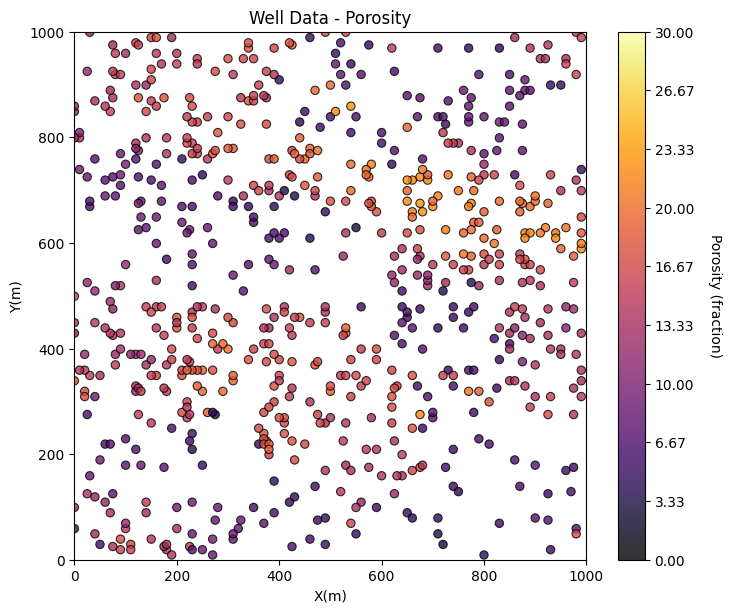

In [10]:
GSLIB.locmap_st(df,'X','Y','Por',xmin,xmax,ymin,ymax,0.0,30.0,'Well Data - Porosity','X(m)','Y(m)',
             'Porosity (fraction)',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2); plt.show()

Maybe we can tighten up the color bar to see more details? and add some gridlines?

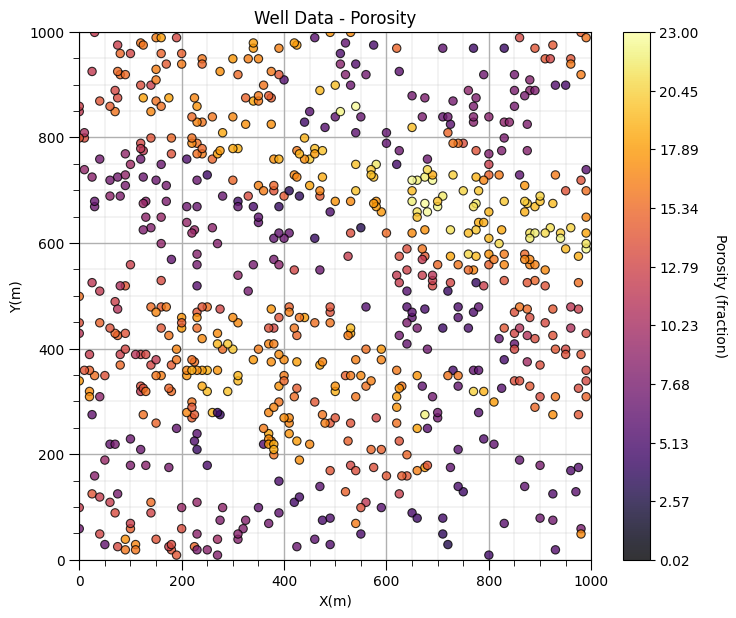

In [11]:
GSLIB.locmap_st(df,'X','Y','Por',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)','Porosity (fraction)',cmap)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.1, wspace=0.1, hspace=0.2)

The new colorbar extents improves the resolution of spatial details for our property. 

We will need ranges for the other variables. I'll pick some:

In [12]:
xmin = 0.0; xmax = 1000.0                                     # range of x values
permmin = 0.01; permmax = 3000;                               # range for permeability
AImin = 1000.0; AImax = 8000                                  # range for facies
Fmin = 0; Fmax = 1                                            # range for acoustic impedance

Let's add the other properties into a composite figure with all the plots as subplots. 

* To do this we use the subplot command, in matplotlib package to prior to the figure command to indicate that the following figure is part of a subplot and we use subplots_adjust at the end to get the scaling right. 

* We can save our fancy figure to an image file with the file format and resolution that we need. 

This is great for writing reports, papers and making great looking update presentations. 

Note, in GeostatsPy, I provide additional ploting methods with and without '_st' in the name.

* with '_st' functions to 'stack' images in a composite figure. 
* without '_st' functions to produce a single image and simultaenously make a file

We can also just make a file after we make our composite plot, see below.

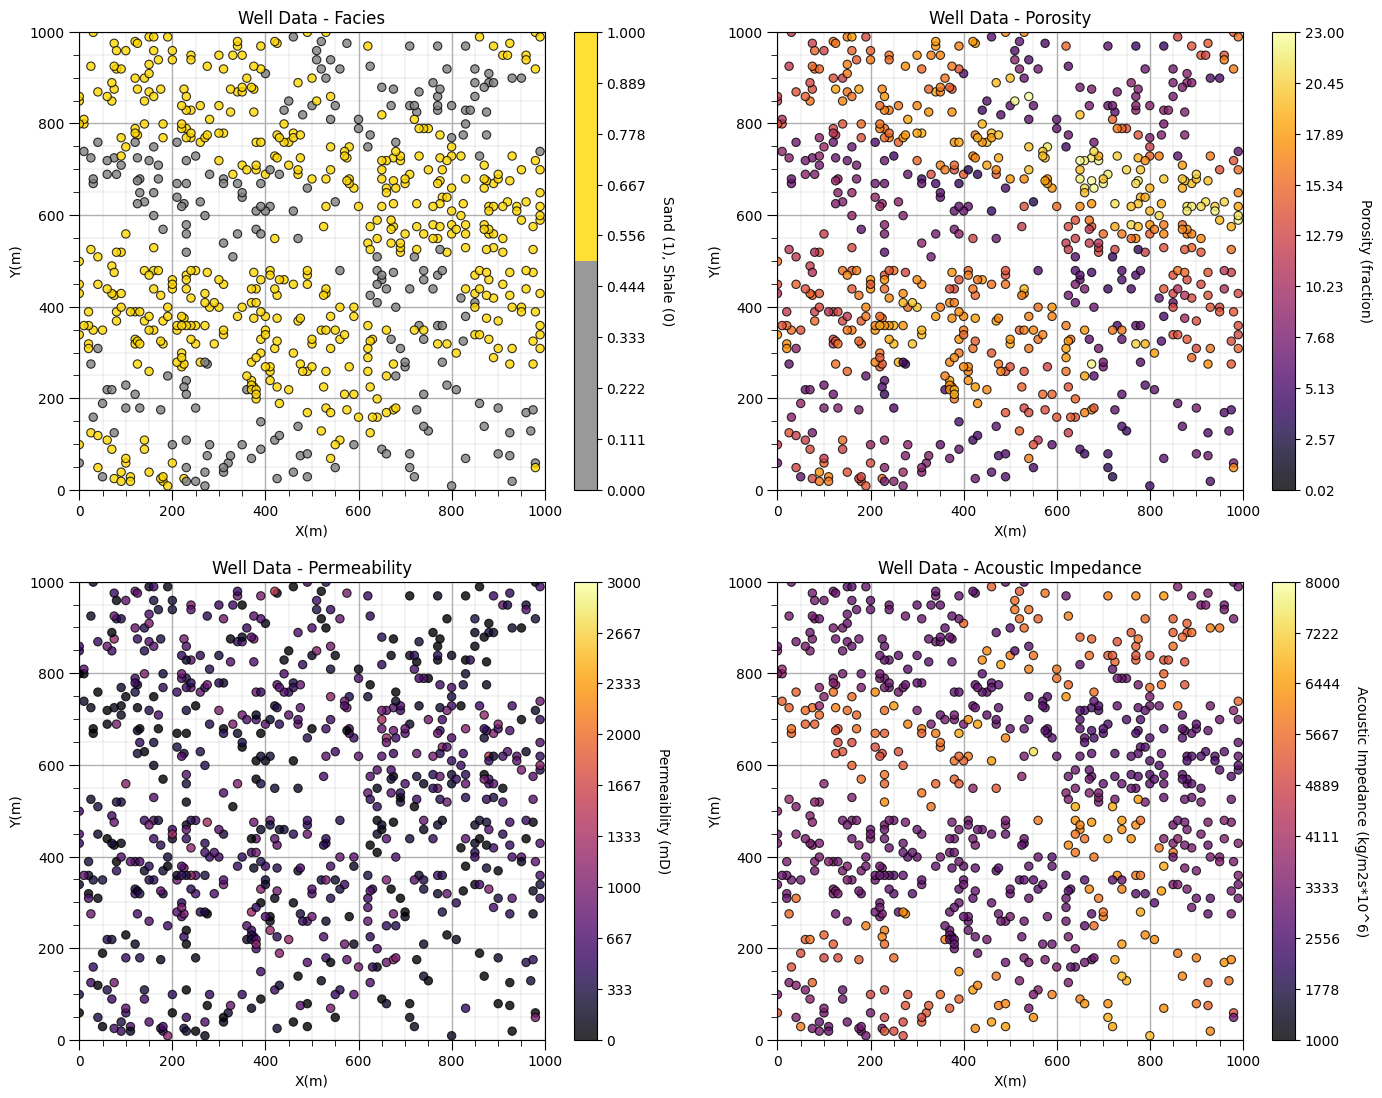

In [13]:
save_to_file = True                                           # save composite image to a file?

plt.subplot(221)
GSLIB.locmap_st(df,'X','Y','Facies',xmin,xmax,ymin,ymax,Fmin,Fmax,'Well Data - Facies','X(m)','Y(m)',
                'Sand (1), Shale (0)',cmap_facies)
add_grid()

plt.subplot(222)
GSLIB.locmap_st(df,'X','Y','Por',xmin,xmax,ymin,ymax,pormin,pormax,'Well Data - Porosity','X(m)','Y(m)',
                'Porosity (fraction)',cmap)
add_grid()

plt.subplot(223)
GSLIB.locmap_st(df,'X','Y','Perm',xmin,xmax,ymin,ymax,permmin,permmax,'Well Data - Permeability','X(m)','Y(m)',
                'Permeaiblity (mD)',cmap)
add_grid()

plt.subplot(224)
GSLIB.locmap_st(df,'X','Y','AI',xmin,xmax,ymin,ymax,AImin,AImax,'Well Data - Acoustic Impedance','X(m)','Y(m)',
                'Acoustic Impedance (kg/m2s*10^6)',cmap)
add_grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.1, wspace=0.2, hspace=0.2)

if save_to_file == True:                                      # make a figure file
    plt.savefig('All_location_maps.tif',dpi=600,bbox_inches="tight")

plt.show()

Looks pretty good, eh? (yes, I am Canadian). 

* Did you notice the custom color map for facies? We could actually update the tick marks on the colorbar, but for brevity let's leave it as is for now.

#### Loading Gridded Data

Let's load and visualize the gridded, exhaustic seismic data set.

In [14]:
seismic = np.loadtxt("https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/spatial_nonlinear_MV_facies_v13_truth_AI.csv", 
                     delimiter=",")                           # load the 2D csv file

Once again, no errors, a good sign. Let's see what we loaded. 

In [15]:
type(seismic)                                                 # check the type of the load object

numpy.ndarray

It is an NumPy ndarray - an array of values. Good!  

Let's get more specific. We can use the 'type' command to find out what any object is and we can use the shape member of ndarray to get the size of the array (ny, nx).

In [16]:
print('The object type is ' + str(type(seismic)))              
print('  with size, ny =  ' + str(seismic.shape[0]) + ' and nx = ' + str(seismic.shape[1])) # check the grid size

The object type is <class 'numpy.ndarray'>
  with size, ny =  100 and nx = 100


#### Visualizing Gridded Data

We have a 100 cells in y and 100 cells in x grid but we need more information. 

* What is the origin, units, orientation and the cell size? 

This file format does not include that information so I'll give it to you. 

* cell size is 10m isotropic (same in x and y)

* grid goes from 0 to 1000m in x and y (origin is at 0,0) 

* grid orientation is aligned with x and y (Eastings and Northings, without any rotation).

We need to add the grid cell size, because we already have the grid extents (xmin, xmax, ymin and ymax) above.

In [17]:
csize = 10.0                                                  # grid cell size

We will use the pixelplt command reimplimented form GSLIB. To see the parameters type the name and run.

In [18]:
GSLIB.pixelplt                                                # GeostatsPy's pixel plot function

<function geostatspy.GSLIB.pixelplt(array, xmin, xmax, ymin, ymax, step, vmin, vmax, title, xlabel, ylabel, vlabel, cmap, fig_name)>

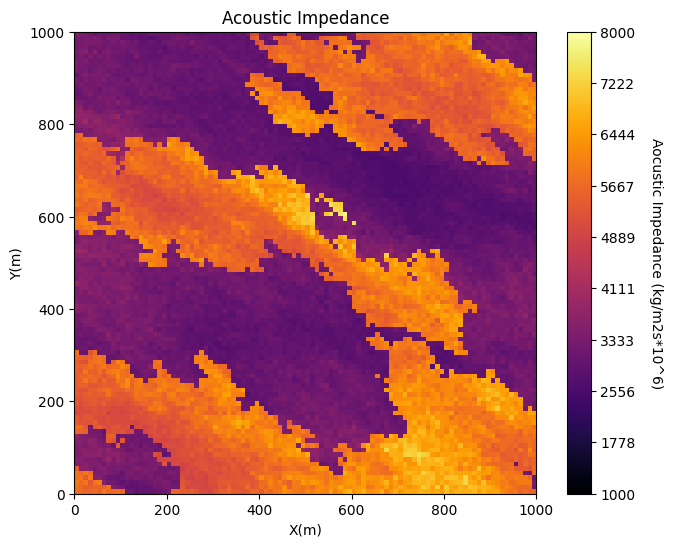

In [19]:
GSLIB.pixelplt(seismic,xmin,xmax,ymin,ymax,csize,AImin,AImax,'Acoustic Impedance','X(m)','Y(m)',
               'Aocustic Impedance (kg/m2s*10^6)',cmap,'pixelplot_Acoustic_Impedance') # plot the seismic data

Interesting, there are a lot of local variations in our subsurface unit in acoustic impedance. If acoustic impedance is well correlated to petrophysical properties then there is a lot of good information here.

#### Visualizing Tabular and Gridded Data Together

You may be concerned about the consistency between the tabular acoustic impedance samples and the gridded acoustic impedance. 

* It is a good check to plot them together. 
* GeostatsPy's locpix is a function to plot tabular and gridded data together. 

In [20]:
GSLIB.locpix                                                  # GeostatsPy's combined tabular and gridd data plot

<function geostatspy.GSLIB.locpix(array, xmin, xmax, ymin, ymax, step, vmin, vmax, df, xcol, ycol, vcol, title, xlabel, ylabel, vlabel, cmap, fig_name)>

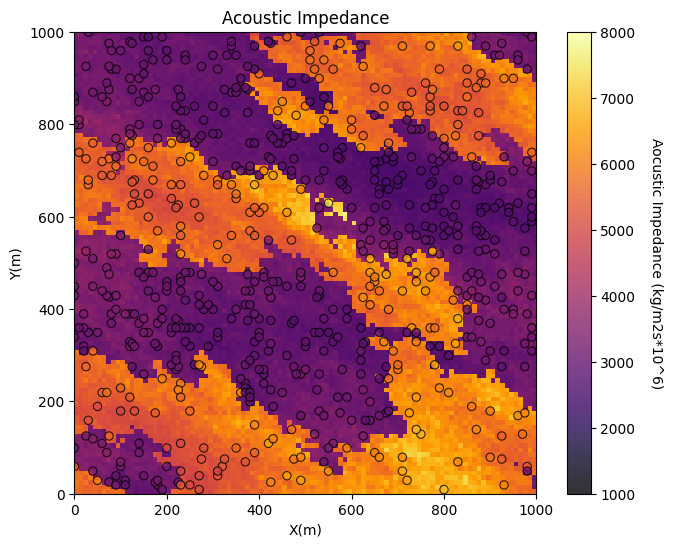

In [21]:
GSLIB.locpix(seismic,xmin,xmax,ymin,ymax,csize,AImin,AImax,df,'X','Y','AI','Acoustic Impedance','X(m)','Y(m)',
             'Aocustic Impedance (kg/m2s*10^6)',cmap,'pixelplot_Acoustic_Impedance')

#### Other Ideas for Interogating Spatial Data

Looks good. There is so much more that we can do to display our spatial data to learn form it. For example, what if we want to separate low and high porosity?  Try this, make a new property in the DataFrame with 0 for low porosity and 1 for high porosity.

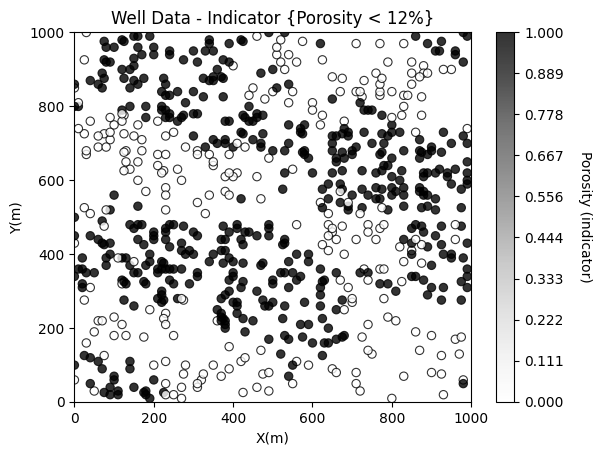

In [63]:
df['cat_por'] = np.where(df['Por']>=12.0,1.0,0.0)

plt.subplot(111)
GSLIB.locmap_st(df,'X','Y','cat_por',xmin,xmax,ymin,ymax,0.0,1.0,
             'Well Data - Indicator {Porosity < 12%}','X(m)','Y(m)','Porosity (indicator)',cmap=plt.cm.Greys)
plt.show()

#### Comments

This was a basic demonstration of plotting spatial data with GeostatsPy. Much more can be done, I have other demonstrations for modeling workflows with GeostatsPy in the GitHub repository [GeostatsPy_Demos](https://github.com/GeostatsGuy/GeostatsPy_Demos/tree/main).

I hope this is helpful,

*Michael*

#### The Author:

### Michael Pyrcz, Professor, The University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  